# Model Agnostic Supervised Local Explanations

Run the Model Agnostic Supervised Local Explanations (MAPLE) in order to produce fully interpretable predictions for single instances. RF or GBM are fitted to the black-box model predictions and are used to weight training instances according to the frequency of appearence in the same leaf node of a specified instance. Features are ranked and then selected using a linear model by adding sequentially one by one the features and retaining those that improve a given metric. Finally, an interpretable linear model is fitted locally by weighting the training samples and using only the selected predictors.  

In [1]:
import xarray as xr
import netCDF4
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sys
import gc
import geopandas as gpd
import rioxarray as rxr
from shapely.geometry import box
from affine import Affine
import sys
import seaborn as sns
import rasterio
import os
from collections import defaultdict
import random
from methods.maple import Maple 
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, plot_precision_recall_curve
from utils.utils import print_instance

In [2]:
import warnings
warnings.filterwarnings('ignore')

Upload UC3 data: 

In [3]:
df = pd.read_csv(r"C:\Users\unknown\Desktop\repos\DC\data\greece_pixel_dataset.csv")

In [4]:
list(df.columns)

['Fpar_500m',
 'Lai_500m',
 'LST_Day_1km',
 'LST_Night_1km',
 '1 km 16 days NDVI',
 '1 km 16 days EVI',
 'ET_500m',
 'LE_500m',
 'PET_500m',
 'PLE_500m',
 'era5_max_u10',
 'era5_max_v10',
 'era5_max_t2m',
 'era5_max_tp',
 'era5_min_u10',
 'era5_min_v10',
 'era5_min_t2m',
 'era5_min_tp',
 'x',
 'y',
 'dem_mean',
 'dem_std',
 'aspect_mean',
 'aspect_std',
 'slope_mean',
 'slope_std',
 'roads_density_2020',
 'population_density',
 'clc',
 'burned_areas',
 'time',
 'datetime']

In [5]:
features = [
 'Fpar_500m',
 'Lai_500m',
 'LST_Day_1km',
 'LST_Night_1km',
 '1 km 16 days NDVI',
 '1 km 16 days EVI',
 'ET_500m',
 'LE_500m',
 'PET_500m',
 'PLE_500m',
 'era5_max_u10',
 'era5_max_v10',
 'era5_max_t2m',
 'era5_max_tp',
 'era5_min_u10',
 'era5_min_v10',
 'era5_min_t2m',
 'era5_min_tp'
]

coordinates = ['x', 'y']

static_features = [ 
 'dem_mean',
 'dem_std',
 'aspect_mean',
 'aspect_std',
 'slope_mean',
 'slope_std',
 'roads_density_2020',
 'population_density',
 'clc'
]

target = 'burned_areas'

Data cleaning and train-test splitting: 

In [6]:
nan_fillvalue = -9999
df = df.fillna(nan_fillvalue)
time_split = int(df.time.max()*0.85)
train_df=df[df['time']<time_split]
test_df=df[df['time']>=time_split]

Fit a Random Forest and plot results: 

              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91      2050
         1.0       0.73      0.61      0.67       634

    accuracy                           0.86      2684
   macro avg       0.81      0.77      0.79      2684
weighted avg       0.85      0.86      0.85      2684



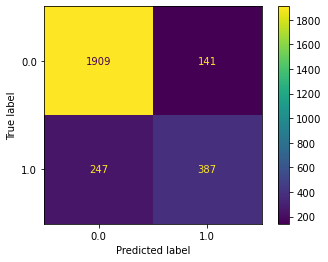

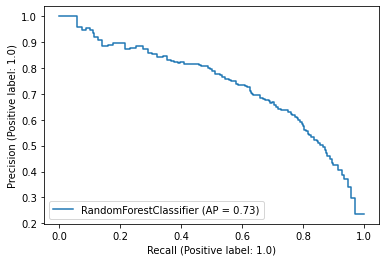

In [7]:
features_to_exclude = [
 'Fpar_500m',
 'Lai_500m',
#  'LST_Day_1km',
#  'LST_Night_1km',
#  '1 km 16 days NDVI',
#  '1 km 16 days EVI',
 'ET_500m',
 'LE_500m',
 'PET_500m',
 'PLE_500m',
#  'era5_max_u10',
#  'era5_max_v10',
#  'era5_max_t2m',
#  'era5_max_tp',
 'era5_min_u10',
 'era5_min_v10',
 'era5_min_t2m',
 'era5_min_tp',
#  'dem_mean',
 'dem_std',
#  'aspect_mean',
 'aspect_std',
#  'slope_mean',
#  'slope_std',
#  'roads_density_2020',
#  'population_density',
#  'clc'
]
features_filtered = [x for x in features + static_features if x not in features_to_exclude]

X_train, X_test = train_df[features_filtered], test_df[features_filtered]
y_train, y_test = train_df[target], test_df[target]
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

plot_confusion_matrix(clf, X_test, y_test)
plt.show()
plot_precision_recall_curve(clf, X_test, y_test)  
plt.show()

Let us now fit the MAPLE method in order to extract the most relevant features and a local explanation for single instances:

In [8]:
features_filtered

['LST_Day_1km',
 'LST_Night_1km',
 '1 km 16 days NDVI',
 '1 km 16 days EVI',
 'era5_max_u10',
 'era5_max_v10',
 'era5_max_t2m',
 'era5_max_tp',
 'dem_mean',
 'aspect_mean',
 'slope_mean',
 'slope_std',
 'roads_density_2020',
 'population_density',
 'clc']

In [9]:
config = {
    "model": clf,
    "X": np.array(X_train), 
    "features":features_filtered,
    "feature_selector": "rf", 
    "instance":0,
    "n_estimators": 100
}

Fitted  rf  to select features for local approximation of the black-box!
Number of features to retain =  0
Number of features to retain =  1
Number of features to retain =  2
Number of features to retain =  2
Number of features to retain =  2
Number of features to retain =  2
Number of features to retain =  2
Number of features to retain =  2
Number of features to retain =  2
Number of features to retain =  2
Number of features to retain =  2
Number of features to retain =  2
Number of features to retain =  2
Number of features to retain =  2
Number of features to retain =  2


#################################
Selected features by MAPLE : 
LST_Day_1km
LST_Night_1km
#################################


#################################
Instance number :  0
LST_Day_1km  =  -9999.0
LST_Night_1km  =  -9999.0
1 km 16 days NDVI  =  44050000.0
1 km 16 days EVI  =  23060000.0
era5_max_u10  =  0.79484916
era5_max_v10  =  0.31691074
era5_max_t2m  =  280.3381
era5_max_tp  =  0.0016517565
dem_mean

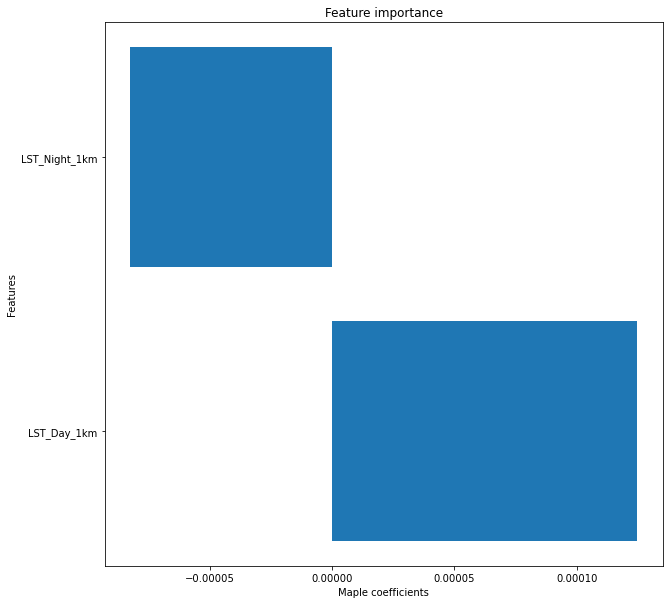



#################################
Closest sample : 
Instance number :  11732
LST_Day_1km  =  284.98
LST_Night_1km  =  -9999.0
Linear model pred =  0.0
#################################


#################################
Farhest sample : 
Instance number :  0
LST_Day_1km  =  315.92
LST_Night_1km  =  299.02
Linear model pred =  0.0
#################################


#################################
Change of class predicted : 


TypeError: only integer scalar arrays can be converted to a scalar index

In [10]:
mpl = Maple(config)
Xred, local_mod, output = mpl.run_all()